# Pan01 Bottom Temperature

**Status:**: files need to be reloaded (notebook rerun) now that temperature fix is in.

In [1]:
import intake
import glob
import dask.distributed as dsk
import matplotlib.pyplot as plt
import xarray as xr
import cf_xarray as cfxr
import numpy as np
import xesmf as xe
import gsw

import cmocean as cm
import cartopy.crs as ccrs

import cartopy.feature as cft
import matplotlib.path as mpath

import warnings # ignore these warnings
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

In [2]:
import logging
logging.getLogger("matplotlib").setLevel(logging.WARNING)

In [40]:
from dask.distributed import Client
client = Client(threads_per_worker=1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/42327/status,
Dashboard: /proxy/42327/status,Workers: 28
Total threads: 28,Total memory: 125.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39481,Workers: 28
Dashboard: /proxy/42327/status,Total threads: 28
Started: Just now,Total memory: 125.19 GiB
Comm: tcp://127.0.0.1:35911,Total threads: 1
Dashboard: /proxy/46281/status,Memory: 4.47 GiB
Nanny: tcp://127.0.0.1:45623,


ERROR:asyncio:Task exception was never retrieved
future: <Task finished name='Task-5794150' coro=<Client._gather.<locals>.wait() done, defined at /g/data/xp65/public/apps/med_conda/envs/analysis3-25.04/lib/python3.11/site-packages/distributed/client.py:2394> exception=AllExit()>
Traceback (most recent call last):
  File "/g/data/xp65/public/apps/med_conda/envs/analysis3-25.04/lib/python3.11/site-packages/distributed/client.py", line 2403, in wait
    raise AllExit()
distributed.client.AllExit
ERROR:asyncio:Task exception was never retrieved
future: <Task finished name='Task-5794312' coro=<Client._gather.<locals>.wait() done, defined at /g/data/xp65/public/apps/med_conda/envs/analysis3-25.04/lib/python3.11/site-packages/distributed/client.py:2394> exception=AllExit()>
Traceback (most recent call last):
  File "/g/data/xp65/public/apps/med_conda/envs/analysis3-25.04/lib/python3.11/site-packages/distributed/client.py", line 2403, in wait
    raise AllExit()
distributed.client.AllExit
ERRO

In [4]:
# Importing data

pathsC = np.sort(glob.glob('/g/data/ol01/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/*/*.ocean_month_z.nc'))
pathsM = np.sort(glob.glob('/g/data/g40/akm157/model_output/mom6-panan/panant-01-zstar-ssp126-MW-only/*/*.ocean_month_z.nc'))

In [5]:
# Shelf mask
shelf_mask = shelf_mask = xr.open_dataset('/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_01deg.nc')['contour_masked_above']

In [6]:
# Time variant variables
def preprocess(ds):
    ds = ds[['thetao', 'volcello','so']].sel(yh=shelf_mask['yh'])
    return ds

cont = xr.open_mfdataset(pathsC, preprocess = preprocess, chunks = 'auto')
melt = xr.open_mfdataset(pathsM, preprocess = preprocess, chunks = 'auto')

In [7]:
#Time slicing
cont = cont.sel(time=slice('2001-01-01','2010-12-31'))
melt = melt.sel(time=slice('2001-01-01','2010-12-31'))

In [8]:
#Time invariant variables
depth = xr.open_dataset('/g/data/ol01/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/output050/20050501.ocean_static.nc')['deptho']
areaC = xr.open_dataset('/g/data/ol01/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/output050/20050501.ocean_static.nc')['areacello'].sel(xh=shelf_mask['xh'])
areaM = xr.open_dataset('/g/data/g40/akm157/model_output/mom6-panan/panant-01-zstar-ssp126-MW-only/output020/20010101.ocean_static.nc')['areacello'].sel(xh=shelf_mask['xh'])

We want to convert into conservative temperature to match ACCESS.  
We will need to:  
- (a) Calculate pressure from depths using `p_from_z` using `z_l` with a minus because the function has the z axis with zero at the surface and positive upwards
- (b) Calculate absolute salinity using `SA_from_SP`
- (c) Calculate conservative temperature using `CT_from_pt`

### Time mean for mapping

In [9]:
cont_map = cont.sel(time=slice('2006-01-01','2010-12-31')).mean(dim='time')
melt_map = melt.sel(time=slice('2006-01-01','2010-12-31')).mean(dim='time')

In [10]:
# Calculating pressure
p_cont = gsw.p_from_z(-cont_map['z_l'], cont_map['yh'])
p_melt = gsw.p_from_z(-melt_map['z_l'], melt_map['yh'])

# Calculating absolute salinity
SA_cont = gsw.SA_from_SP(cont_map['so'], p_cont, cont_map['xh'], cont_map['yh'])
SA_melt =  gsw.SA_from_SP(melt_map['so'], p_melt, melt_map['xh'], melt_map['yh'])

# Calculating conservative temperature
tempC = gsw.CT_from_pt(SA_cont,cont_map['thetao'])
tempM = gsw.CT_from_pt(SA_melt,melt_map['thetao'])

In [11]:
cont_map['thetao']

<xarray.DataArray 'thetao' (z_l: 75, yh: 533, xh: 3600)> Size: 576MB
dask.array<mean_agg-aggregate, shape=(75, 533, 3600), dtype=float32, chunksize=(22, 211, 1030), chunktype=numpy.ndarray>
Coordinates:
  * xh       (xh) float64 29kB -279.9 -279.8 -279.7 -279.6 ... 79.75 79.85 79.95
  * yh       (yh) float64 4kB -79.0 -78.95 -78.91 ... -55.18 -55.12 -55.07
  * z_l      (z_l) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03

In [12]:
tempC = tempC.astype('float32').load()

In [13]:
tempM = tempM.astype('float32').load()

In [15]:
# To fix the label issues
tempC = xr.DataArray(tempC, dims=cont_map['thetao'].dims, coords=cont_map['thetao'].coords)
tempC.attrs['units'] = '°C'
tempC.name = 'CT'

tempM = xr.DataArray(tempM, dims=melt_map['thetao'].dims, coords=melt_map['thetao'].coords)
tempM.attrs['units'] = '°C'
tempM.name = 'CT'

In [19]:
tempM

<xarray.DataArray 'CT' (z_l: 75, yh: 533, xh: 3600)> Size: 576MB
array([[[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [0.1447829 , 0.25544026, 0.38937208, ..., 0.02010373,
         0.02836761, 0.06714916],
        [0.18838836, 0.29720673, 0.42535135, ..., 0.03438967,
         0.05297682, 0.10390218],
        [0.23331112, 0.33878517, 0.45773032, ..., 0.0547241 ,
         0.08536731, 0.14699751]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
...
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]]], dtype=float32)
Coordinates:
  * xh       (xh) float64 29kB -279.9 -279.8 -279.7 -279.6 ... 79.75 79.85 79.95
  * yh       (yh) float64 4kB -79.0 -78.95 -78.91 ... -55.18 -55.12 -55.07
  * z_l      (z_l) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
Attributes:
    units:    °C

Doing the bottom mask:

In [17]:
bottom_mask_tempC = tempC.where(~np.isfinite(tempC.shift({'z_l': -1})))
bottom_mask_tempC = ~np.isnan(bottom_mask_tempC)

In [18]:
bottom_mask_tempM = tempM.where(~np.isfinite(tempM.shift({'z_l': -1})))
bottom_mask_tempM = ~np.isnan(bottom_mask_tempM)

#### Mapping

In [20]:
bottemp_cont_map = tempC.where(bottom_mask_tempC).sum(dim='z_l')
bottemp_pert_map = tempM.where(bottom_mask_tempM).sum(dim='z_l')
bottemp_anom_map = bottemp_pert_map - bottemp_cont_map

In [21]:
bottemp_anom_map = bottemp_anom_map.load()

In [22]:
land_mask = (0 * depth).fillna(1)
land = xr.where(np.isnan(depth.rename('land')), 1, np.nan)
projection = ccrs.SouthPolarStereo()

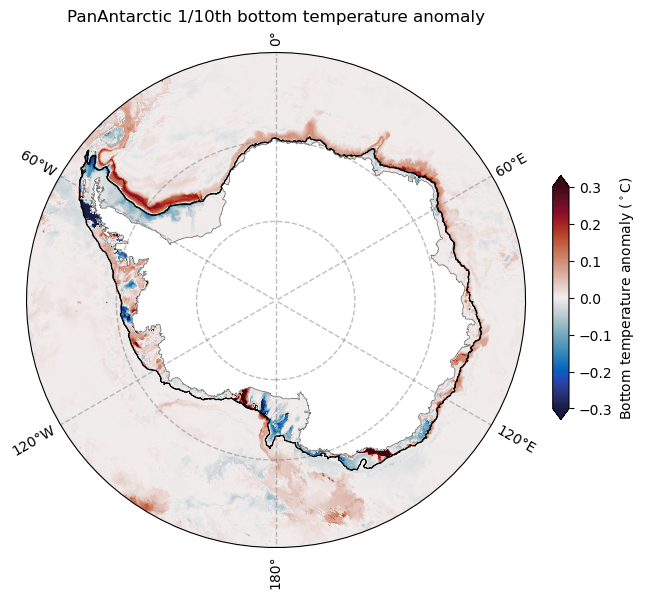

In [27]:
# With conservative temperature

projection = ccrs.SouthPolarStereo()
    
plt.figure(figsize=(7, 8))
ax = plt.axes(projection=projection)
ax.set_extent([-280, 80, -80, -59], crs=ccrs.PlateCarree())
    
# Circular boundary
theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5,0.495], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

# Filled land 
land.plot.contourf(ax=ax, colors='white',
                   zorder=2,
                   transform=ccrs.PlateCarree(),
                   add_colorbar=False)

# Coast line
ax.contour(land_mask.cf['X'], land_mask.cf['Y'], land_mask,
           levels = [0, 1], colors = 'dimgrey',linewidths=0.5, transform = ccrs.PlateCarree())
# Shelf contour
ax.contour(shelf_mask.cf['X'], shelf_mask.cf['Y'], shelf_mask,
           levels = [0, 1], colors = 'k', linewidths=0.4,transform = ccrs.PlateCarree())

# Adding polar axes
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, 
                    xlocs=range(-180,171,60), ylocs=[], 
                    color='gray', alpha=0.5, linestyle='--', zorder=10)
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=1, 
                    xlocs=[], ylocs=(-80,-70,-55), 
                    color='gray', alpha=0.5, linestyle='--', zorder=10)

# Plotting
bottemp_anom_map.plot(
    x="xh",
    y="yh",
    transform=ccrs.PlateCarree(),
    vmin=-0.3,
    vmax=0.3,
    extend="both",
    cmap=cm.cm.balance, #cm ocean colour maps for more options, matplotlib has more also.
    cbar_kwargs={"label": "Bottom temperature anomaly ($^\circ$C)", "fraction": 0.03, "aspect": 15, "shrink": 0.7},
);

plt.title("PanAntarctic 1/10th bottom temperature anomaly");

### Time series

In [28]:
# Variable for landmask
saltC = cont['so']
saltM = melt['so']

In [29]:
# Correcting area
areaC_corr = areaC*saltC.isel(time=0,z_l=0)*0 +1
areaM_corr = areaM*saltM.isel(time=0,z_l=0)*0 +1

In [30]:
areaC_corr

<xarray.DataArray (yh: 533, xh: 3600)> Size: 8MB
dask.array<add, shape=(533, 3600), dtype=float32, chunksize=(211, 1030), chunktype=numpy.ndarray>
Coordinates:
  * xh       (xh) float64 29kB -279.9 -279.8 -279.7 -279.6 ... 79.75 79.85 79.95
  * yh       (yh) float64 4kB -79.0 -78.95 -78.91 ... -55.18 -55.12 -55.07
    z_l      float64 8B 0.5413
    time     object 8B 2001-01-16 12:00:00

#### Time series

In [83]:
# Spatial average
cont_time = (areaC_corr * cont).sum(['xh', 'yh']) / areaC_corr.sum(['xh', 'yh'])
melt_time = (areaM_corr * melt).sum(['xh', 'yh']) / areaM_corr.sum(['xh', 'yh'])

In [84]:
# Calculating pressure
p_cont = gsw.p_from_z(-cont_time['z_l'], cont['yh'])
p_melt = gsw.p_from_z(-melt_time['z_l'], melt['yh'])

# Calculating absolute salinity
SA_cont = gsw.SA_from_SP(cont_time['so'], p_cont, cont['xh'], cont['yh'])
SA_melt =  gsw.SA_from_SP(melt_time['so'], p_melt, melt['xh'], melt['yh'])

# Taking mean
SA_cont = SA_cont.mean(dim=['xh','yh'])
SA_melt = SA_melt.mean(dim=['xh','yh'])

# Calculating conservative temperature
tempC = gsw.CT_from_pt(SA_cont,cont_time['thetao'])
tempM = gsw.CT_from_pt(SA_melt,melt_time['thetao'])

In [85]:
tempC

<xarray.DataArray 'so' (time: 120, z_l: 75)> Size: 72kB
dask.array<ct_from_pt, shape=(120, 75), dtype=float64, chunksize=(2, 22), chunktype=numpy.ndarray>
Coordinates:
  * z_l      (z_l) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * time     (time) object 960B 2001-01-16 12:00:00 ... 2010-12-16 12:00:00

In [86]:
tempC = tempC.astype('float32').load()

KeyboardInterrupt: 

In [ ]:
tempM = tempM.astype('float32').load()

In [ ]:
# To fix the label issues
tempC = xr.DataArray(tempC, dims=cont_time['thetao'].dims, coords=cont_time['thetao'].coords)
tempC.attrs['units'] = '°C'
tempC.name = 'CT'

tempM = xr.DataArray(tempM, dims=melt_time['thetao'].dims, coords=melt_time['thetao'].coords)
tempM.attrs['units'] = '°C'
tempM.name = 'CT'

In [ ]:
bottom_mask_tempC = tempC.where(shelf_mask == 0).where(~np.isfinite(tempC.shift({'z_l': -1})))
bottom_mask_tempC = ~np.isnan(bottom_mask_tempC)

In [ ]:
bottom_mask_tempM = tempM.where(shelf_mask == 0).where(~np.isfinite(tempM.shift({'z_l': -1})))
bottom_mask_tempM = ~np.isnan(bottom_mask_tempM)

In [ ]:
bottemp_cont = tempC.where(bottom_mask_tempC).sum(dim='z_l')
bottemp_pert = tempM.where(bottom_mask_tempM).sum(dim='z_l')

In [ ]:
bottemp_cont

In [63]:
# Restrict to shelf
botsalt_cont_shelf = botsalt_cont.where(shelf_mask == 0)
botsalt_pert_shelf = botsalt_pert.where(shelf_mask == 0)

<xarray.DataArray 'CT' (time: 120, z_l: 75)> Size: 9kB
array([[False, False, False, ..., False, False,  True],
       [False, False, False, ..., False, False,  True],
       [False, False, False, ..., False, False,  True],
       ...,
       [False, False, False, ..., False, False,  True],
       [False, False, False, ..., False, False,  True],
       [False, False, False, ..., False, False,  True]])
Coordinates:
  * z_l      (z_l) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * time     (time) object 960B 2001-01-16 12:00:00 ... 2010-12-16 12:00:00
Attributes:
    units:    °C

In [49]:
botsalt_cont_shelf = botsalt_cont_shelf.load()
botsalt_pert_shelf = botsalt_pert_shelf.load()

Text(0.5, 1.0, 'ACCESS Time Series of Bottom Temperature on Shelf')

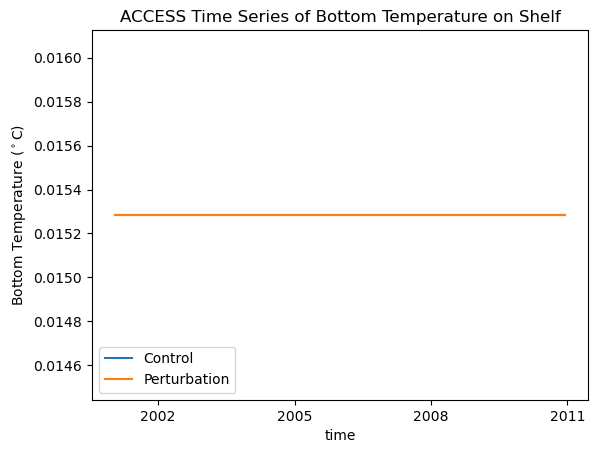

In [50]:
botsalt_cont_shelf.plot(label="Control")
botsalt_pert_shelf.plot(label="Perturbation")
#plt.xlim(380,4000)
#plt.ylim(-1.30,-0.70)
plt.ylabel("Bottom Temperature ($^\circ$C)")
plt.legend(loc="lower left")
plt.title("ACCESS Time Series of Bottom Temperature on Shelf")

In [42]:
bottemp_anom_time = bottemp_pert - bottemp_cont
bottemp_anom_time = bottemp_anom_time.load()

In [44]:
bottemp_anom_time.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/bottemp_anom_CT_pan01.nc')

### Comparison with ACCESS

In [45]:
pan01_bottemp_anom = xr.open_dataarray('/g/data/g40/kc5856/access_panan_ssp126_SWMT/bottemp_anom_CT_pan01.nc', chunks = 'auto')
acc_bottemp_anom = xr.open_dataarray('/g/data/g40/kc5856/access_panan_ssp126_SWMT/access_bottemp_anom.nc', chunks = 'auto') # to update

In [46]:
pan01_bottemp_anom_new = pan01_bottemp_anom.to_series()
acc_bottemp_anom_new = acc_bottemp_anom.to_series()

In [47]:
import pandas as pd

In [48]:
# Slice 1910–1919 and 2001–2010
pan01_bottemp_anom_new = pan01_bottemp_anom_new['2001-01-01':'2010-10-16']
acc_bottemp_anom_new = acc_bottemp_anom_new['1910-01-01':'1919-10-16']

# Reset index to normalized months
pan01_bottemp_anom_new.index = range(1, len(pan01_bottemp_anom_new)+1)
acc_bottemp_anom_new.index = range(1, len(acc_bottemp_anom_new)+1)

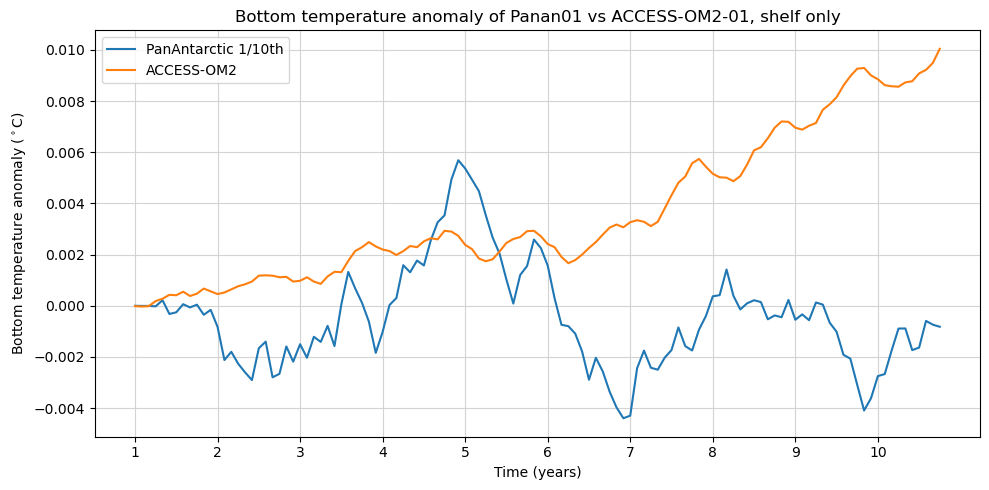

In [49]:
# Create the plot
plt.figure(figsize=(10, 5))
plt.plot(pan01_bottemp_anom_new.index, pan01_bottemp_anom_new.values, label='PanAntarctic 1/10th')
plt.plot(acc_bottemp_anom_new.index, acc_bottemp_anom_new.values, label='ACCESS-OM2')

# Set x-axis ticks to represent years 1 through 10
plt.xticks(ticks=range(1, 121, 12), labels=[str(i) for i in range(1, 11)])

# Labeling and formatting
plt.xlabel('Time (years)')
plt.ylabel("Bottom temperature anomaly ($^\circ$C)")
plt.title('Bottom temperature anomaly of Panan01 vs ACCESS-OM2-01, shelf only')
plt.legend()
plt.grid(True, color='lightgrey')
plt.tight_layout()
plt.show()

### Old plot with potential temperature for PanAntarctic and conservative temperature for ACCESS-OM2

Discard when rerunning with new meltwater experiments.

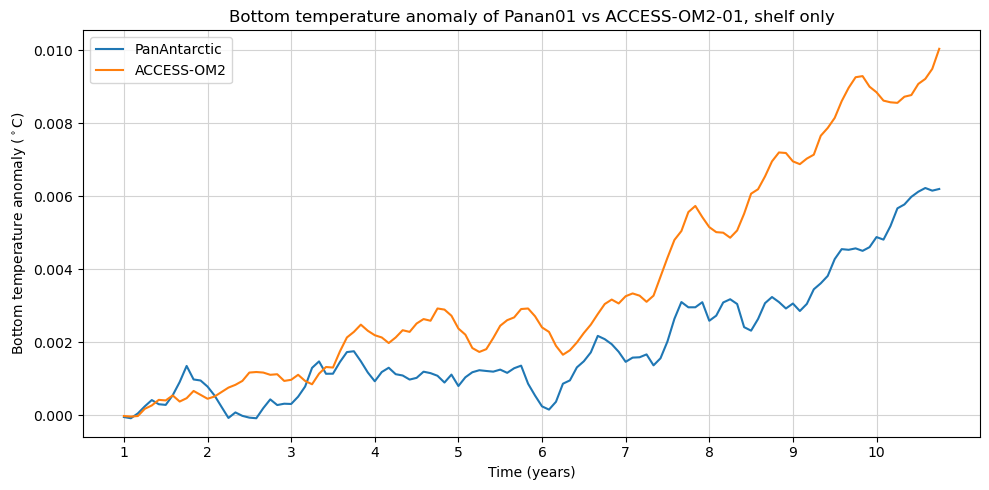

In [41]:
# Create the plot
plt.figure(figsize=(10, 5))
plt.plot(pan01_bottemp_anom_new.index, pan01_bottemp_anom_new.values, label='PanAntarctic')
plt.plot(acc_bottemp_anom_new.index, acc_bottemp_anom_new.values, label='ACCESS-OM2')

# Set x-axis ticks to represent years 1 through 10
plt.xticks(ticks=range(1, 121, 12), labels=[str(i) for i in range(1, 11)])

# Labeling and formatting
plt.xlabel('Time (years)')
plt.ylabel("Bottom temperature anomaly ($^\circ$C)")
plt.title('Bottom temperature anomaly of Panan01 vs ACCESS-OM2-01, shelf only')
plt.legend()
plt.grid(True, color='lightgrey')
plt.tight_layout()
plt.show()